In [100]:
%matplotlib inline
import pandas as pd
from gqlalchemy import Memgraph
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import pickle

import networkx as nx
import tnetwork as tn
import tnetwork.DCD.externals
from sklearn.preprocessing import OneHotEncoder

from scipy.sparse import csr_matrix, vstack, hstack
from scipy.sparse.linalg import norm
import scipy

import Levenshtein as levenshtein

from pymongo import MongoClient
from networkx.algorithms.similarity import optimize_graph_edit_distance as oged
from networkx.algorithms.community import louvain_partitions, louvain_communities

sim = "no_network"

In [2]:
# with open(f"last_step_no_network.pickle", mode="rb") as file:
#     G = pickle.load(file)
# Make a connection to the database
def get_mongo_db():
    client = MongoClient("mongodb://localhost:27017")
    db = client["no_network"]
    return db

db = get_mongo_db()
db = db["level_1_edges"]

cursor = db.find({"step": 1_000_000}, {"_id": 0, "from_id": 1, "to_id": 1, "weight": 1})

edges = pd.DataFrame(list(cursor))
G = nx.from_pandas_edgelist(edges, source="from_id", target="to_id", edge_attr="weight", create_using=nx.Graph)

In [3]:
coms_df = pd.DataFrame()
coms_df["id"] = range(len(G.nodes()))
coms_df.set_index("id", inplace=True)
coms_df

""
id
0
1
2
3
4
...
4995
4996
4997


In [143]:
def plot_resolution_vs_modularity(data, level=4):
    plt.close("all")
    fig, ax = plt.subplots()
    ax.plot(data["resolution"], data["modularity"], marker="o")
    eps = 0.002
    for i, row in data.iterrows():
        an = ax.annotate(f"{row['size']:.2f}", (row["resolution"] + eps, row["modularity"]  + eps))
        # an.set_in_layout(False)
    # ax.annotate("Number annotates\namount of communities", (0.7, 0.595))
    ax.set_xlabel("Resolution")
    ax.set_ylabel("Modularity")
    ax.spines[['right', 'top']].set_visible(False)
    plt.tight_layout()
    plt.savefig(f"Resolution_vs_modularity_{level}.pdf")

In [19]:
pos = pd.read_csv("neuron_positions.csv")
pos = pos.groupby(pos.index // 10).aggregate(np.mean).drop(columns=["id", "area_id"])
coms_df["level_1"] = pos.index

print(pos)

              x           y          z
0     88.056130  143.893945  83.272579
1     88.262038  143.954972  81.270251
2     90.028444  142.859647  83.475615
3     88.653040  142.789323  86.316839
4     85.568174  143.857699  87.006799
...         ...         ...        ...
4995  84.190236    1.031508  76.645572
4996  88.143353    1.002297  77.117767
4997  88.664860    1.894958  81.271092
4998  85.572988    1.905247  81.905293
4999  86.788609    1.935656  80.002085

[5000 rows x 3 columns]


In [42]:
# print(G.edges(data=True))
partition_level_4 = louvain_communities(G, weight="weight", resolution=1)
p = partition_level_4
# print(p)
c = [next(i for i, community in enumerate(p) if n in community) for n in sorted(G.nodes)]
# print(len(c))
coms_df["level_4"] = c



In [35]:
client = MongoClient("mongodb://localhost:27017")
collection = client["brain"]["hierarchy"]
cursor = collection.find({}, {"_id": 0, "community_level4": 1, "community_level1": 1})
hierarchy = pd.DataFrame(list(cursor)).drop_duplicates().reset_index(drop=True)
print(hierarchy)
coms_df["level_4"] = hierarchy["community_level4"]

      community_level1  community_level4
0                    0                 0
1                    1                 0
2                    2                 0
3                    3                 0
4                    4                 0
...                ...               ...
4995              4995                 8
4996              4996                 8
4997              4997                 8
4998              4998                 8
4999              4999                 8

[5000 rows x 2 columns]


In [29]:
coms_df["level_4"]

id
0       0
1       0
2       0
3       0
4       0
       ..
4995    8
4996    8
4997    8
4998    8
4999    8
Name: level_4, Length: 5000, dtype: int64

In [17]:
nx.algorithms.community.modularity(G, partition_level_4, weight="weight")

0.6574149512098999

In [8]:
def hash_community(community_id, parent_id):
    return hash(f"{parent_id}_{community_id}")

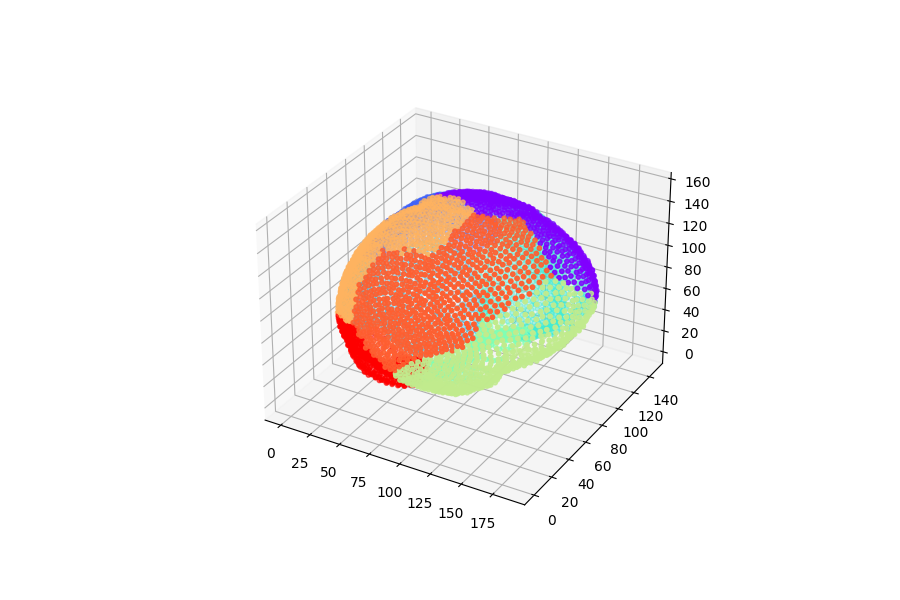

In [43]:
plt.close("all")
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection="3d")

# print("communities:", len(set(getattr(newdf, f"c{step}"))))
# size of points 5
ax.scatter(pos.x, pos.y, pos.z, c=coms_df["level_4"], s=10, marker="o", cmap="rainbow")
plt.show()

In [147]:
colors = ["red", "green", "blue", "yellow", "magenta", "cyan", "white", "black", ]

def evaluation_resolutions(G, verbose=False, from_=0.1, to=2, steps=10):
    df = pd.DataFrame(columns=["resolution", "size", "modularity"])
    for r in np.linspace(from_, to, steps):
        subpartition = louvain_communities(G, weight="weight", resolution=r)
        modularity = nx.algorithms.community.modularity(G, subpartition, weight="weight")
        if verbose:
            print(f"resolution: {r}, {len(subpartition)=}, {modularity=}")
        df = pd.concat([df, pd.DataFrame({"resolution": r, "size": len(subpartition), "modularity": modularity}, index=[0])], ignore_index=True)

    return df

def evaluation_resolutions_for_partition(G, partition):
    avg = pd.DataFrame(columns=["resolution", "size", "modularity"])
    # not green or red
    for community in tqdm(partition, colour=np.random.choice(colors)):
        subG = G.subgraph(community)
        res = evaluation_resolutions(subG)
        avg = pd.concat([avg, res], ignore_index=True)
    avg = avg.groupby("resolution").mean().reset_index()

    return avg

def best_resolution(df):
    return df.sort_values("modularity", ascending=False).iloc[0]

res_level4 = evaluation_resolutions_for_partition(G, partition_level_4)
best = best_resolution(res_level4)


100%|██████████| 9/9 [01:14<00:00,  8.30s/it]


In [140]:
res_level5 = evaluation_resolutions(G, verbose=True, from_=0.1, to=2, steps=10)

resolution: 0.1, len(subpartition)=1, modularity=0.0
resolution: 0.3111111111111111, len(subpartition)=4, modularity=0.596442893821542
resolution: 0.5222222222222223, len(subpartition)=6, modularity=0.6379447592401548
resolution: 0.7333333333333333, len(subpartition)=7, modularity=0.6468109253848564
resolution: 0.9444444444444444, len(subpartition)=8, modularity=0.659085739728292
resolution: 1.1555555555555557, len(subpartition)=11, modularity=0.6573969798948642
resolution: 1.3666666666666667, len(subpartition)=12, modularity=0.6493943119201115
resolution: 1.577777777777778, len(subpartition)=14, modularity=0.6418438540189463
resolution: 1.788888888888889, len(subpartition)=15, modularity=0.6373028837383018
resolution: 2.0, len(subpartition)=16, modularity=0.6331197405844498


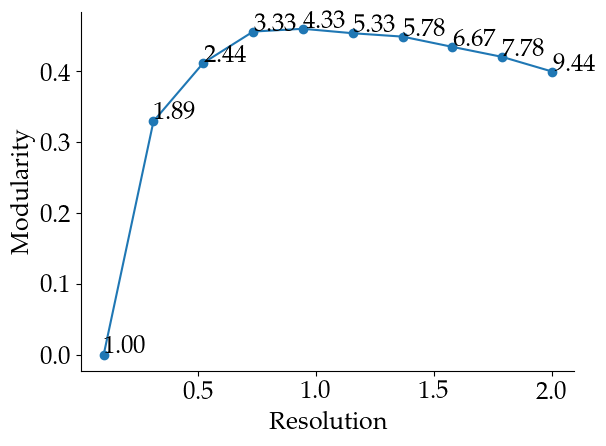

In [148]:

# from matplotlib import rc

# rc('font', **{'family': 'serif', 'serif': ['Palatino'], 'size': 18})
# rc('text', usetex=True)

plot_resolution_vs_modularity(res_level4, level=4)

In [149]:
def sub_partition(partition, G, resolution):
    subpartitions = []
    coloring = {}
    for i in range(len(partition)):
        partition_i = partition[i]
        subG = G.subgraph(partition_i)
        subpartition = louvain_communities(subG, weight="weight", resolution=resolution)
        subpartitions.extend(subpartition)
        c = {n: next(i for i in range(len(p)) if n in subpartition[i]) for n in subG.nodes}
        coloring |= c
    return subpartitions, coloring

In [150]:
partition_level_3, coloring_level_3 = sub_partition(partition_level_4, G, 1.7)
sorted_coloring = [v for k, v in sorted(coloring_level_3.items(), key=lambda item: item[0])]
coms_df["level_3"] = sorted_coloring

In [152]:
res_level3 = evaluation_resolutions_for_partition(G, partition_level_3)
best = best_resolution(res_level3)

100%|██████████| 66/66 [00:42<00:00,  1.54it/s]


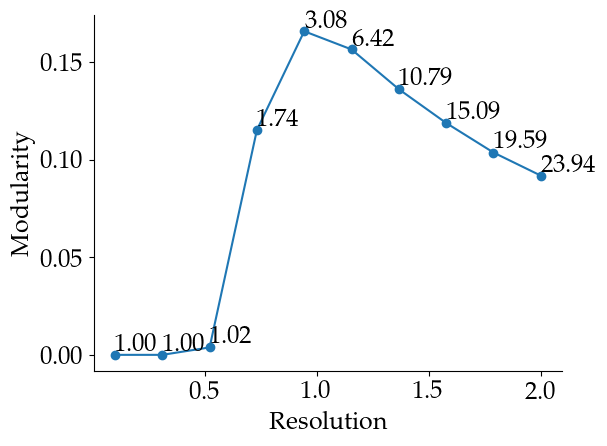

In [153]:
plot_resolution_vs_modularity(res_level3, level=3)

In [124]:
partition_level_2, coloring_level_2 = sub_partition(partition_level_3, G, 1)

sorted_coloring_level_2 = [v for k, v in sorted(coloring_level_2.items(), key=lambda item: item[0])]
coms_df["level_2"] = sorted_coloring_level_2

In [132]:


# nx.algorithms.community.modularity(G, partition_level_2, weight="weight")
m4 = nx.algorithms.community.modularity(G, partition_level_4, weight="weight")
m3 = nx.algorithms.community.modularity(G, partition_level_3, weight="weight")
m2 = nx.algorithms.community.modularity(G, partition_level_2, weight="weight")

print(f"Size level 4: {len(partition_level_4)}, Size level 3: {len(partition_level_3)}, Size level 2: {len(partition_level_2)}")
print(f"{m4=}, {m3=}, {m2=}")
import statistics

print(max([len(p) for p in partition_level_2]), np.mean([len(p) for p in partition_level_2]), min([len(p) for p in partition_level_2]), statistics.stdev([len(p) for p in partition_level_2]))
print(max([len(p) for p in partition_level_3]), np.mean([len(p) for p in partition_level_3]), min([len(p) for p in partition_level_3]), statistics.stdev([len(p) for p in partition_level_3]))
print(max([len(p) for p in partition_level_4]), np.mean([len(p) for p in partition_level_4]), min([len(p) for p in partition_level_4]), statistics.stdev([len(p) for p in partition_level_4]))


Size level 4: 9, Size level 3: 66, Size level 2: 244
m4=0.6509140448174232, m3=0.4275998071928673, m2=0.21526226427192693
56 20.491803278688526 1 12.550963369736467
140 75.75757575757575 7 29.403328229227913
798 555.5555555555555 416 128.13772971992978


In [134]:
statistics.stdev([10]*50000)

0.0

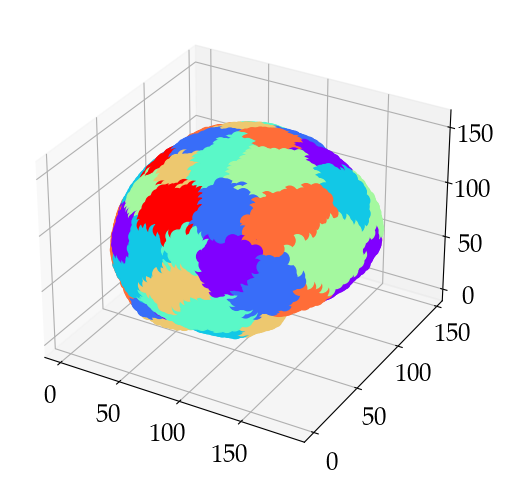

In [128]:
plt.close("all")
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection="3d")
# print("communities:", len(set(getattr(newdf, f"c{step}"))))
pos2 = pos.copy()
# pos2 = pos2.loc[list(partition_level_4[2])]
ax.scatter(pos2.x, pos2.y, pos2.z, c=(coms_df["level_3"].loc[pos2.index]), s=100, marker="o", cmap="rainbow", alpha=1)
plt.show()

In [56]:
coms_df["level_3_v2"] = coms_df[["level_3", "level_4"]].apply(lambda x: hash("_".join(map(str, x))), axis=1)
coms_df["level_3_v3"] = coms_df["level_3_v2"].astype("category").cat.codes
coms_df["level_2_v2"] = coms_df[["level_2", "level_3", "level_4"]].apply(lambda x: hash("_".join(map(str, x))), axis=1)
coms_df["level_2_v3"] = coms_df["level_2_v2"].astype("category").cat.codes

coms_df

,level_1,level_4,level_3,level_2,level_2_v2,level_3_v2,level_3_v3,level_2_v3
id,,,,,,,,
651,651,1,2,1,-2190711150626650412,-8811145798763452063,0,95
917,917,1,2,1,-2190711150626650412,-8811145798763452063,0,95
565,565,1,2,1,-2190711150626650412,-8811145798763452063,0,95
564,564,1,2,0,-3181061677538326550,-8811145798763452063,0,80
563,563,1,2,0,-3181061677538326550,-8811145798763452063,0,80
...,...,...,...,...,...,...,...,...
3128,3128,7,4,0,2379678847740580484,8960498776818643310,65,149
3129,3129,7,4,0,2379678847740580484,8960498776818643310,65,149
2147,2147,7,4,2,-6714559670280980221,8960498776818643310,65,39


In [57]:
# save coms_ds to a csv
correct_coms_df = coms_df[["level_1", "level_2_v3", "level_3_v3", "level_4"]].copy()
correct_coms_df.rename(columns={"level_1": "level_1", "level_2_v3": "level_2", "level_3_v3": "level_3", "level_4": "level_4"}, inplace=True)
correct_coms_df.to_csv("coms_df.csv")